In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [14]:
DATA_DIR = r"../data/processed/BP_npy/pulseDB/test_2.npy"

In [146]:

def estimate_period_autocorr(signal,use_one=True,plot=False):
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(signal)-1:]  # 正方向のみ
    if plot:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(autocorr)
        
        plt.title("Autocorrelation")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.subplot(2, 1, 2)
        plt.plot(np.diff(autocorr))
        plt.show()
    # plt.plot(autocorr)
    # ピークを探す（0除く）
    peaks = np.diff(np.sign(np.diff(autocorr))) < 0
    peak_indices = np.where(peaks)[0]
    if len(peak_indices) > 1:
        zero = peak_indices[0]
        cond = peak_indices>42
        if cond.any() and use_one:
            return peak_indices[cond].min()
        else:
            return zero  # 1番目のピークが周期
    else:
        return None

In [4]:
def estimate_period_fft(signal, sampling_rate):
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft), d=1.0/sampling_rate)
    magnitude = np.abs(fft)
    pos_freqs = freqs[:len(freqs)//2]
    pos_magnitude = magnitude[:len(magnitude)//2]
    peak_index = np.argmax(pos_magnitude[1:]) + 1  # DC成分を除く
    peak_freq = pos_freqs[peak_index]
    if peak_freq != 0:
        return peak_freq 
    else:
        return None

In [5]:
def plot_fft(signal, sampling_rate):
    data_fft = np.fft.fft(signal) 
    amplitude = np.abs(data_fft)
    amplitude_db = 20 * np.log10(amplitude + 1e-10) 
    freqs = np.fft.fftfreq(len(data_fft), d=1.0/sampling_rate)
    # print(np.argsort(-amplitude[1:])[:3])
    print("top 3 frequencies",freqs[np.argsort(-amplitude[1:len(freqs)//2])[:3]+1])
    # plt.plot(freqs[1:len(freqs)//2], amplitude_db[1:len(freqs)//2])
    plt.plot(freqs[1:len(freqs)//2-500], amplitude_db[1:len(freqs)//2-500])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('FFT Spectrum (in dB)')
    plt.grid()

In [48]:
data  = np.load(DATA_DIR)
print(data.shape)
sampling_rate = 125  # サンプリングレート（Hz）


(38110, 2, 1250)


In [37]:
i = np.random.randint(0, data.shape[0])
signal = data[i,1]
plot_fft(signal, sampling_rate)

NameError: name 'sampling_rate' is not defined

139

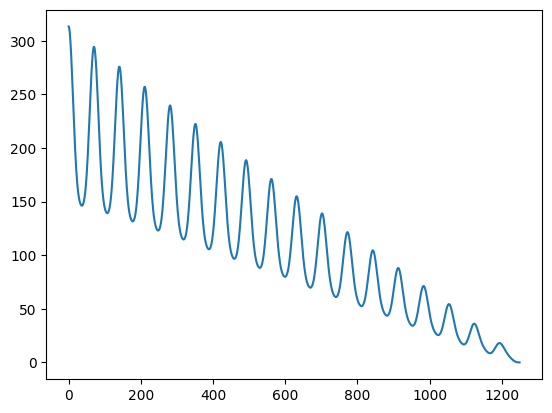

In [49]:
estimate_period_autocorr(signal)

In [6]:
def split_and_plot(signal, n):
    # 信号を n の長さで分割（端数切り捨て）
    num_segments = len(signal) // n
    segments = np.array(np.split(signal[:num_segments * n], num_segments))

    # プロット（各区間を縦に並べる）
    plt.figure(figsize=(10, 6))
    for i, seg in enumerate(segments):
        plt.plot(seg, label=f"Segment {i+1}", alpha=0.6)
    
    plt.title(f"Waveform Segments (Length {n})")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    
    return segments

In [55]:
estimate_period_autocorr(signal),estimate_period_autocorr(signal)/sampling_rate,estimate_period_fft(signal, sampling_rate),estimate_period_fft(signal, sampling_rate)*sampling_rate

(139, 1.112, 1.8, 225.0)

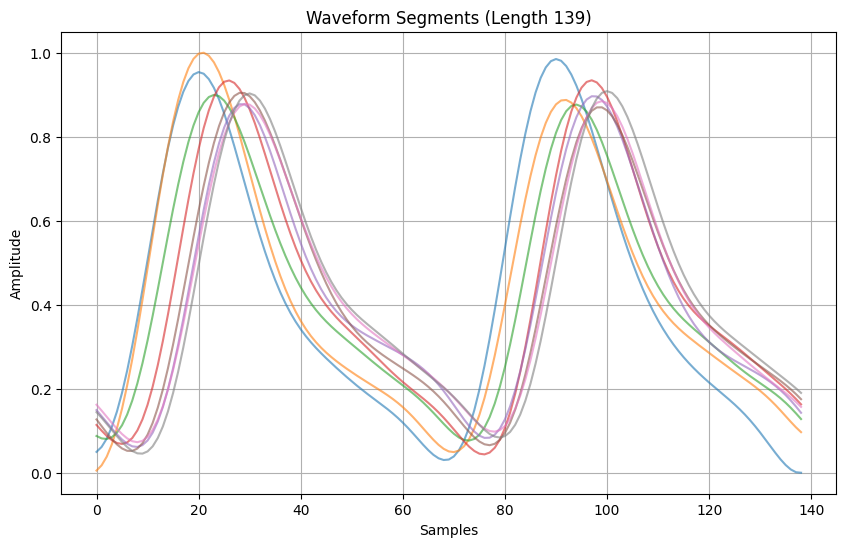

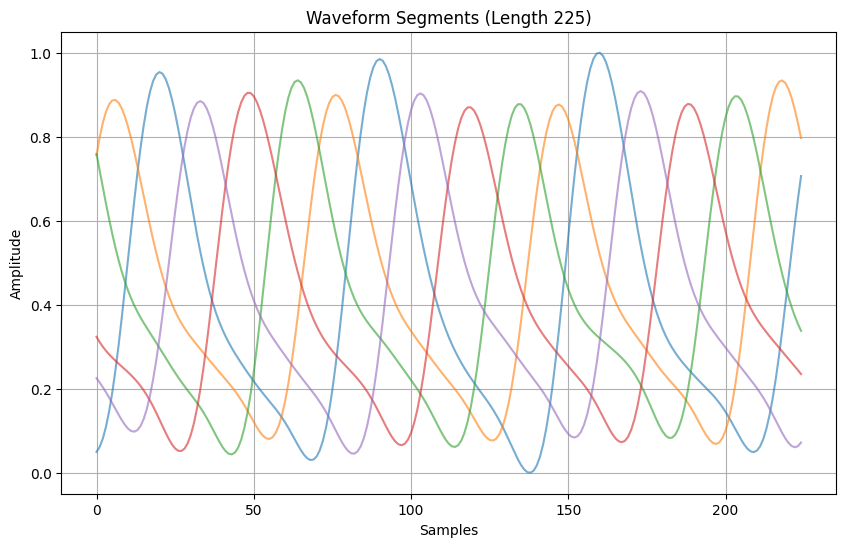

(array([[0.04956636, 0.06143515, 0.08108528, ..., 0.00766335, 0.00121986,
         0.        ],
        [0.00511632, 0.01757557, 0.03817796, ..., 0.12100861, 0.10811554,
         0.09661723],
        [0.08746272, 0.08169701, 0.08039525, ..., 0.15442776, 0.14149376,
         0.12779803],
        ...,
        [0.12687007, 0.11073342, 0.09489848, ..., 0.19845526, 0.18725036,
         0.17507063],
        [0.16189668, 0.14788181, 0.13331957, ..., 0.17927849, 0.16844277,
         0.15678373],
        [0.14419226, 0.13067831, 0.11639751, ..., 0.21115015, 0.2008856 ,
         0.19003135]]),
 array([[0.04956636, 0.06143515, 0.08108528, ..., 0.59105785, 0.65104472,
         0.70641353],
        [0.7558454 , 0.79826776, 0.83288796, ..., 0.86502798, 0.83275391,
         0.79692574],
        [0.75877402, 0.71944724, 0.67998027, ..., 0.37312048, 0.35439232,
         0.33794643],
        [0.32357907, 0.31104554, 0.30008955, ..., 0.25333402, 0.2442424 ,
         0.23487212],
        [0.22507014, 0.21

In [46]:
split_and_plot(signal, 139),split_and_plot(signal, 225)

In [124]:
import torch
import torch.nn.functional as F


def torch_correlate_full(a, v):
    a = a.view(1, 1, -1)
    v = v.view(1, 1, -1)

    # パディングのサイズは len(v) - 1
    padding = v.shape[-1] - 1
    a_padded = F.pad(a, (padding, padding))

    out = F.conv1d(a_padded, v)  # correlation: filter is NOT flipped
    return out.view(-1)

def estimate_period_autocorr_torch(signal: torch.Tensor,plot=False):
    n = signal.size(0)
    signal = signal - torch.mean(signal)  # バイアス除去（オプション）
    autocorr = torch_correlate_full(signal, signal)

    autocorr = autocorr[n - 1:]  # 正方向のみ
    diff1 = torch.diff(autocorr)
    if plot:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(autocorr.numpy())
        
        plt.title("Autocorrelation")
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.subplot(2, 1, 2)
        plt.plot(diff1.numpy())
        plt.show()
    diff2 = torch.diff(torch.sign(diff1))
    peaks = (diff2 < 0).nonzero(as_tuple=False).squeeze()

    if peaks.numel() > 1:
        return peaks[1].item()
    else:
        return None

(232, 233)

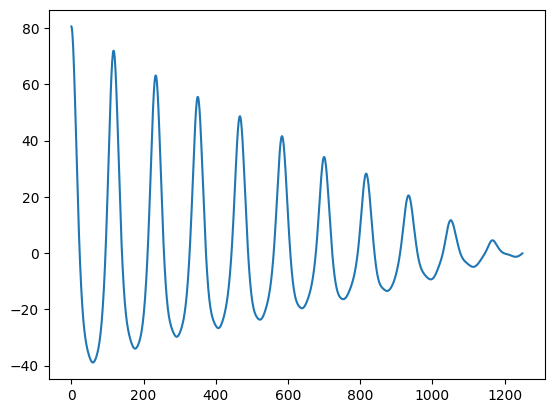

In [75]:
i = np.random.randint(0, data.shape[0])
signal= data[i]
estimate_period_autocorr(signal),estimate_period_autocorr_torch(torch.Tensor(signal))

(111, 87)

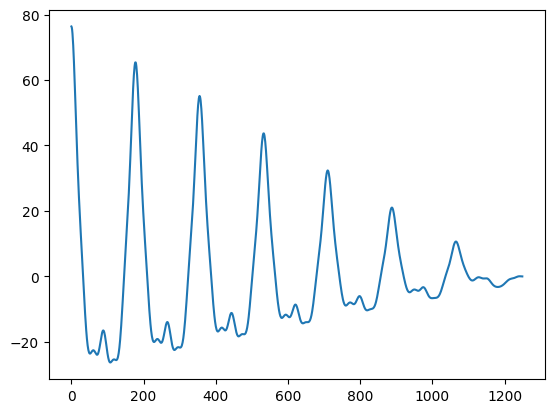

Estimated period: 139


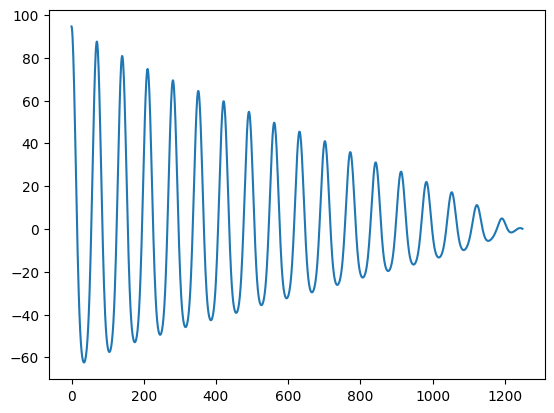

In [71]:
torch_signal = torch.tensor(signal, dtype=torch.float32)

# 関数を通して周期推定
estimated_period = estimate_period_autocorr_torch(torch_signal)
print(f"Estimated period: {estimated_period}")

In [127]:
def batch_estimate_period_autocorr_torch(batch_signal: torch.Tensor):
    """
    batch_signal: (B, N) のテンソル（B: バッチ数, N: サンプル数）
    """
    B, N = batch_signal.shape
    # print(f"Batch shape: {batch_signal.shape}")
    signal = batch_signal - batch_signal.mean(dim=1, keepdim=True)
    padding = signal.shape[-1] - 1
    signal_padded = F.pad(signal.view(1, B, N), (padding, padding))
    autocorr = F.conv1d(
        signal_padded,                       # (B, 1, N)
        signal.unsqueeze(1),
        # padding= N - 1,    # (B, 1, N)
        groups=B
    ).squeeze(0)[:, N-1:]
    # print(autocorr.shape)
    # plt.plot(autocorr[1].cpu().numpy())# 結果: (B, N)
    diff1 = torch.diff(autocorr, dim=1)  # (B, N-1)
    diff2 = torch.diff(torch.sign(diff1), dim=1)    # (B, N-2)
    peaks = (diff2 < 0).int()

    # diff2が負の値になった位置（ピーク）を
    periods = []
    for i in range(B):
        peak_indices = peaks[i].nonzero().squeeze()
        if peak_indices.numel() > 1:
            periods.append(peak_indices[1].item())  # 最初のピークの位置（1を加える）
        else:
            periods.append(None)
    
    return periods
from joblib import Parallel, delayed
def batch_estimate_period_parallel(batch_data,use_one=True):
    return np.array(Parallel(n_jobs=-1)(delayed(estimate_period_autocorr)(sig,use_one) for sig in batch_data))


In [91]:
import time
data = np.load(r"../data/processed/BP_npy/pulseDB/train_2.npy")[:,1]
start = time.time()
period_numpy = batch_estimate_period_parallel(data)
elapsed_numpy = time.time() - start
print(f"[NumPy] Time: {elapsed_numpy:.6f} sec")
batch_size=512
# PyTorch 実行時間
# start = time.time()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# period_torch = []
# for i in range(0,len(data),batch_size):
#     signal = data[i:i+batch_size]
#     signal = torch.tensor(signal, dtype=torch.float32, device=device, requires_grad=False).squeeze()
#     # print(signal.shape)
#     period_torch.extend(batch_estimate_period_autocorr_torch(signal))
#     signal = signal.cpu()
# # torch_signal = torch.tensor(signal, dtype=torch.float32, device=device)
# # period_torch = batch_estimate_period_autocorr_torch(torch_signal)
# elapsed_torch = time.time() - start
# print(f"[Torch] Time: {elapsed_torch:.6f} sec")

[NumPy] Time: 11.534540 sec


In [131]:
torch.cuda.empty_cache()

In [78]:
period_numpy = np.array(period_numpy)
period_numpy.shape

(38110,)

In [79]:

period_torch = np.array(period_torch)

In [80]:
period_numpy-period_torch

array([-1, -1, -1, ..., -1, -2, -1], dtype=int64)

(array([1.0000e+00, 1.2058e+04, 8.6734e+04, 9.3824e+04, 5.4008e+04,
        1.9745e+04, 7.5070e+03, 9.4840e+03, 9.5430e+03, 5.4460e+03,
        6.0440e+03, 3.0250e+03, 3.2590e+03, 1.3530e+03, 1.3600e+02,
        1.3300e+02, 5.8000e+01, 4.7000e+01, 3.6000e+01, 1.0000e+00]),
 array([ 19.08396947,  36.87977099,  54.67557252,  72.47137405,
         90.26717557, 108.0629771 , 125.85877863, 143.65458015,
        161.45038168, 179.24618321, 197.04198473, 214.83778626,
        232.63358779, 250.42938931, 268.22519084, 286.02099237,
        303.81679389, 321.61259542, 339.40839695, 357.20419847,
        375.        ]),
 <BarContainer object of 20 artists>)

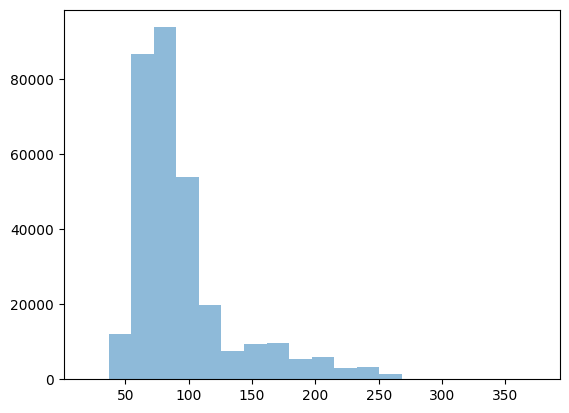

In [92]:
plt.hist(60/(np.array(period_numpy)/125), bins=20, alpha=0.5, label='NumPy')

In [ ]:
plt.hist(60/(np.array(period_numpy)/125), bins=20, alpha=0.5, label='NumPy')

In [ ]:
plt.hist(np.array(period_numpy)()

array([ 94, 134, 106, ...,  92,  84,  95], dtype=int64)

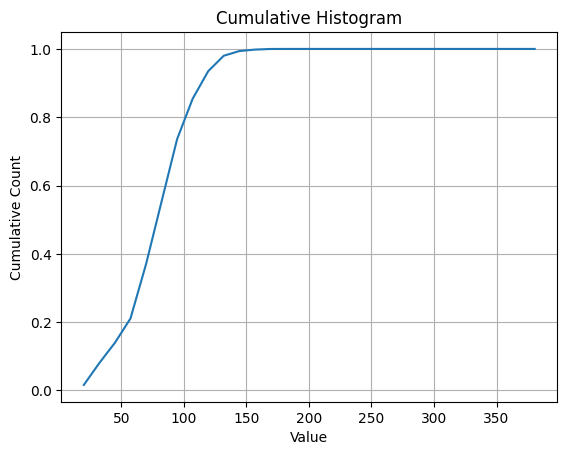

In [98]:
# counts, bins = np.histogram(60/(np.array(period_numpy)/125), bins=30)
counts, bins = np.histogram(np.array(period_numpy), bins=30)

# 累積ヒストグラムに変換
cumulative_counts = np.cumsum(counts)

# 描画
plt.plot(bins[:-1], cumulative_counts/len(period_numpy))
plt.title("Cumulative Histogram")
plt.xlabel("Value")
plt.ylabel("Cumulative Count")
plt.grid(True)
plt.show()

In [103]:
np.where(np.array(period_numpy)==21)

(array([144418, 254467, 254472, 254514, 254544, 254562, 254581, 254584,
        254591, 254652, 254661, 254705], dtype=int64),)

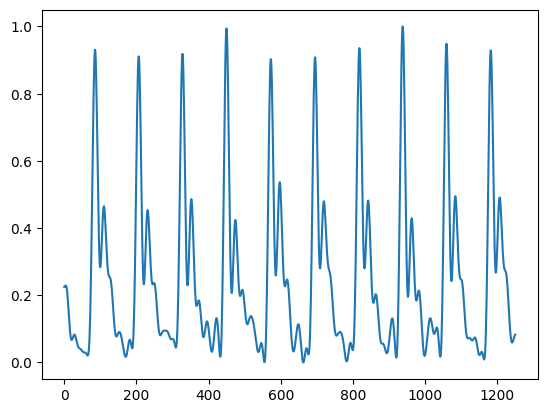

In [ ]:
plt.plot(data[144418])

In [ ]:
plt.plot(data[144418])

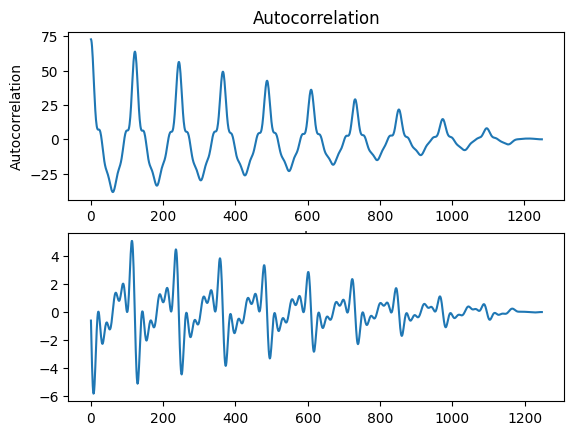

99

In [125]:
estimate_period_autocorr_torch(torch.tensor(data[144418], dtype=torch.float32),plot=True)

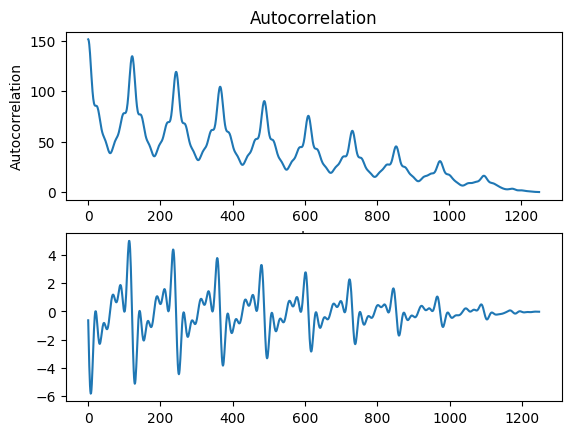

21

In [113]:
estimate_period_autocorr(data[144418],plot=True)

In [96]:
for i in range(1,20):
    print(i,1250//i)

1 1250
2 625
3 416
4 312
5 250
6 208
7 178
8 156
9 138
10 125
11 113
12 104
13 96
14 89
15 83
16 78
17 73
18 69
19 65


In [ ]:
period_numpy = estimate_period_autocorr(data[144418],plot=True)
plt.hist(60/(np.array(period_numpy)/125), bins=20, alpha=0.5, label='NumPy')

In [147]:
period_numpy = batch_estimate_period_parallel(data,use_one=False)
period_numpy2 = batch_estimate_period_parallel(data,use_one=True)


In [149]:
max(period_numpy2),min(period_numpy2)

(393, 43)

# 心拍数

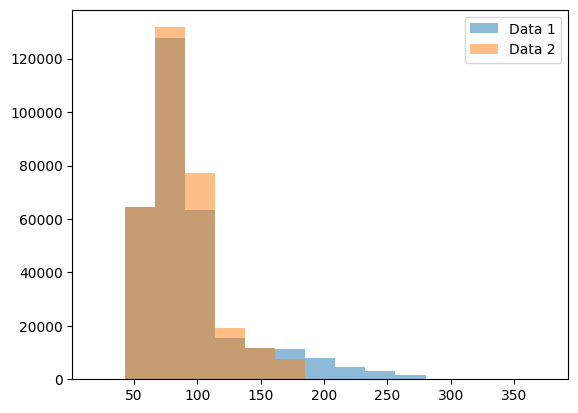

In [148]:
counts1, bins = np.histogram(60/(np.array(period_numpy)/125), bins=15)

# data2のビンをdata1に合わせてヒストグラム
counts2, _ = np.histogram(60/(np.array(period_numpy2)/125), bins=bins)

# プロット
plt.hist(bins[:-1], bins=bins, weights=counts1, alpha=0.5, label="Data 1")
plt.hist(bins[:-1], bins=bins, weights=counts2, alpha=0.5, label="Data 2")
plt.legend()

# 実際のデータセットのポイント数


(array([2.7326e+04, 5.7549e+04, 9.2286e+04, 7.0427e+04, 4.3440e+04,
        1.6275e+04, 4.2790e+03, 8.2400e+02, 3.4000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 43. ,  60.5,  78. ,  95.5, 113. , 130.5, 148. , 165.5, 183. ,
        200.5, 218. , 235.5, 253. , 270.5, 288. , 305.5, 323. , 340.5,
        358. , 375.5, 393. ]),
 <BarContainer object of 20 artists>)

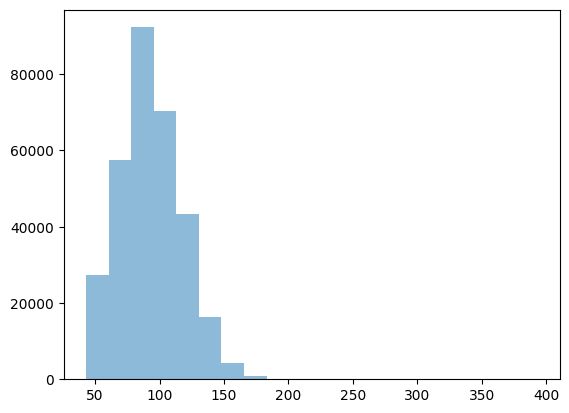

In [150]:
plt.hist(period_numpy2, bins=20, alpha=0.5, label='NumPy')

In [167]:
period_numpy3 = np.where(period_numpy2 > 138, 138, period_numpy2)
period_numpy4 = np.where(period_numpy3 < 69, period_numpy3*2, period_numpy3)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

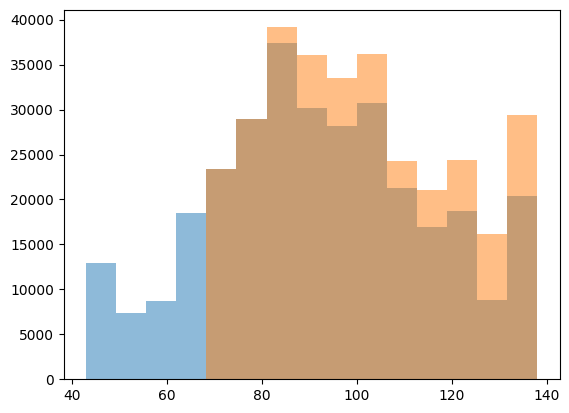

In [168]:
counts3, bins3 = np.histogram(period_numpy3, bins=15)

# data2のビンをdata1に合わせてヒストグラム
counts4, _ = np.histogram(period_numpy4, bins=bins3)

# plt.hist(period_numpy2, bins=20, alpha=0.5, label='NumPy')
plt.hist(bins3[:-1], bins=bins3, weights=counts3,alpha=0.5, label='NumPy')
plt.hist(bins3[:-1], bins=bins3, weights=counts4,alpha=0.5, label='NumPy')
plt.legend